In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions_configs import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

import PyMieScatt as pms
from analyzing_functions import *

seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Load models

In [2]:
model_name_iv = 'forward_model/surrogate_model'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_iv5_F11/models'

model_name_fw = 'forward_model/surrogate_model'
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw5_F11/models'
plot_dir= '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw5_F11/plots_meas'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [3]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

In [4]:
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)


# Load data

In [5]:
# measurement data  - need to be divided by (4*np.pi)
#meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_values.h5'
#dvar_meas = pd.read_hdf(meas_datafile,'dvar')

meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221219.h5'
dvar_meas = pd.read_hdf(meas_datafile,'param')


qoi_meas = pd.read_hdf(meas_datafile,'qoi')


qoi_meas

F11_0.532_10 F11_0.532_11 F11_0.532_12 F11_0.532_13 F11_0.532_14  \
0     10.239827    10.194808    10.145547    10.092117    10.034599   
1     326.86447    321.21155    315.10266    308.56677    301.63461   
2     160.12137    156.38988    152.37726    148.10745    143.60559   
3     249.96579    237.15302     223.7457    209.90463    195.79099   
4     235.75613    211.91342    187.91399    164.21085     141.2289   
5     11.752591    11.707408    11.657947    11.604275    11.546465   
6     30.748764    30.595501    30.427883    30.246176    30.050674   
7     75.704582    75.110214    74.462082    73.761749    73.010887   
8     158.11987    156.57832    154.89992    153.08939    151.15178   
9     128.23978    126.72509    125.07919    123.30756    121.41608   
10    262.51611     258.0994    253.32208    248.20578    242.77332   
11    196.29445    191.89273    187.15506    182.10863    176.78203   
12    379.23856    367.91727    355.81595     343.0239    329.63391   
13    137.42064    130.41521    123.07205    115.47595    107.71186   

   F11_0.532_15 F11_0.532_16 F11_0.532_17 F11_0.532_18 F11_0.532_19  ...  \
0      9.973075     9.898133     9.812126     9.780692     9.713143  ...   
1     294.33823   274.810342   273.276961   267.670406    256.42997  ...   
2     138.89772   147.105122    133.24079   114.931483   109.322211  ...   
3     181.56351   157.498141    131.03587   101.940804    72.543582  ...   
4     119.35442    71.961964    57.870742    49.497148    41.000065  ...   
5     11.484595    11.318596    11.203328    11.143059    11.132492  ...   
6     29.841686    29.746688     29.56951    29.268835    28.897714  ...   
7     72.211281    65.265902    64.064075    63.030589    62.087433  ...   
8      149.0925   139.418343   136.915128   135.413765   133.908431  ...   
9     119.41093   114.638491   112.756318    110.20757   107.400512  ...   
10    237.04869    213.72616    209.10027   206.119219   200.170367  ...   
11    171.20494   158.477975   153.810887   146.616963   139.183722  ...   
12    315.74103   292.228769   284.521563   260.474723    240.43224  ...   
13    99.863449    94.076989    90.692855    81.414035    68.016267  ...   

   PPF_0.532_161 PPF_0.532_162 PPF_0.532_163 PPF_0.532_164 PPF_0.532_165  \
0       0.061826      0.057134      0.052089      0.040751      0.040911   
1      -0.441232     -0.401337     -0.368562     -0.334364     -0.309479   
2      -0.741377     -0.693725     -0.681174     -0.632558     -0.602007   
3      -0.575589     -0.536714     -0.507962     -0.553993     -0.525728   
4      -0.523141      -0.50454     -0.472679     -0.416469     -0.317612   
5       0.081484      0.078445      0.070497       0.06563      0.061137   
6       0.152212      0.129584      0.104234      0.093521      0.085057   
7      -0.066784     -0.085836     -0.094277     -0.059041     -0.053655   
8       0.020547      0.022647      0.022047      0.016791       0.03127   
9       0.250642      0.212366      0.177127      0.172673      0.174824   
10     -0.093295     -0.077207     -0.074237     -0.087953     -0.076371   
11      0.002308      0.013184      0.001364      -0.03792     -0.012979   
12      0.136368      0.122509      0.104022      0.090523      0.108632   
13      0.055255     -0.011847     -0.014415      0.085851     -0.048677   

   PPF_0.532_166 PPF_0.532_167 PPF_0.532_168 PPF_0.532_169 PPF_0.532_170  
0       0.044564      0.038592      0.033057      0.027956      0.023287  
1      -0.249522     -0.216496     -0.185668     -0.157119     -0.130907  
2      -0.396607     -0.344951      -0.29593     -0.250108     -0.207876  
3      -0.412606     -0.357914     -0.305482     -0.256474     -0.211591  
4      -0.356307     -0.296748     -0.241971     -0.193755     -0.152567  
5       0.037566      0.032521      0.027848      0.023544      0.019608  
6       0.064963      0.056329      0.048305      0.040894      0.034097  
7      -0.094474     -0.082034     -0.070424     -0.059

In [6]:
# Pymiescatt simulation of dvar_meas - truncated angles need to be removed
qoi_meas_pymiescatt = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5',key='qoi')
qoi_meas_pymiescatt

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [7]:
# Processed version of qoi_meas - need to be divided by (4*np.pi)
#qoi_meas_preprocessed = pd.read_csv('/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_qoi.txt')

#qoi_meas_preprocessed = qoi_meas_preprocessed.drop(['Unnamed: 0'], axis = 1)
#qoi_meas_preprocessed


meas_datafile_preprocessed = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221220.h5'
dvar_meas_preprocessed = pd.read_hdf(meas_datafile_preprocessed,'param')

qoi_meas_preprocessed = pd.read_hdf(meas_datafile_preprocessed,'qoi')
qoi_meas_preprocessed

F11_0.532_10 F11_0.532_11 F11_0.532_12 F11_0.532_13 F11_0.532_14  \
0     10.239827    10.194808    10.145547    10.092117    10.034599   
1     326.86447    321.21155    315.10266    308.56677    301.63461   
2     160.12137    156.38988    152.37726    148.10745    143.60559   
3     249.96579    237.15302     223.7457    209.90463    195.79099   
4     235.75613    211.91342    187.91399    164.21085     141.2289   
5     11.752591    11.707408    11.657947    11.604275    11.546465   
6     30.748764    30.595501    30.427883    30.246176    30.050674   
7     75.704582    75.110214    74.462082    73.761749    73.010887   
8     158.11987    156.57832    154.89992    153.08939    151.15178   
9     128.23978    126.72509    125.07919    123.30756    121.41608   
10    262.51611     258.0994    253.32208    248.20578    242.77332   
11    196.29445    191.89273    187.15506    182.10863    176.78203   
12    379.23856    367.91727    355.81595     343.0239    329.63391   
13    137.42064    130.41521    123.07205    115.47595    107.71186   

   F11_0.532_15 F11_0.532_16 F11_0.532_17 F11_0.532_18 F11_0.532_19  ...  \
0      9.973075     9.907636     9.838376     9.765396     9.688802  ...   
1     294.33823    286.71097    278.78708    270.60162    262.19009  ...   
2     138.89772    134.01062    128.97156    123.80804    118.54761  ...   
3     181.56351    167.37581    153.37401    139.69453    126.46206  ...   
4     119.35442    98.925941     80.22715    63.481689    48.849827  ...   
5     11.484595    11.418749    11.349015    11.275488    11.198265  ...   
6     29.841686    29.619547    29.384605    29.137228    28.877802  ...   
7     72.211281    71.364807     70.47345    69.539268    68.564407  ...   
8      149.0925    146.91719    144.63177    142.24245    139.75555  ...   
9     119.41093    117.29861    115.08589    112.77979     110.3875  ...   
10    237.04869    231.05679     224.8233    218.37454    211.73721  ...   
11    171.20494    165.40796    159.42224    153.27936    147.01094  ...   
12    315.74103    301.44171    286.83267    272.00998    257.06799  ...   
13    99.863449    92.011734    84.233818    76.601868    69.181999  ...   

   PPF_0.532_161 PPF_0.532_162 PPF_0.532_163 PPF_0.532_164 PPF_0.532_165  \
0       0.081034      0.072851      0.065115      0.057823      0.050974   
1      -0.442524     -0.400883     -0.360518     -0.321694     -0.284636   
2      -0.660275     -0.611036     -0.558628     -0.504535      -0.45013   
3      -0.638159     -0.609828      -0.56966     -0.521175     -0.467822   
4      -0.580507     -0.558302     -0.522558     -0.474301     -0.417153   
5       0.068454      0.061512      0.054955       0.04878      0.042984   
6       0.117186      0.105547      0.094501      0.084052      0.074205   
7      -0.167922     -0.151881     -0.136464     -0.121726     -0.107716   
8       0.011969      0.013367      0.014146      0.014395        0.0142   
9       0.192151      0.175165      0.158521      0.142335      0.126713   
10     -0.087538     -0.083462     -0.078723     -0.073427     -0.067688   
11     -0.050779     -0.041434     -0.032962     -0.025375     -0.018693   
12      0.166831      0.153275      0.139661      0.126198      0.113069   
13      0.040776       0.05445      0.071118       0.09077        0.1131   

   PPF_0.532_166 PPF_0.532_167 PPF_0.532_168 PPF_0.532_169 PPF_0.532_170  
0       0.044564      0.038592      0.033057      0.027956      0.023287  
1      -0.249522     -0.216496     -0.185668     -0.157119     -0.130907  
2      -0.396607     -0.344951      -0.29593     -0.250108     -0.207876  
3      -0.412606     -0.357914     -0.305482     -0.256474     -0.211591  
4      -0.356307     -0.296748     -0.241971     -0.193755     -0.152567  
5       0.037566      0.032521      0.027848      0.023544      0.019608  
6       0.064963      0.056329      0.048305      0.040894      0.034097  
7      -0.094474     -0.082034     -0.070424     -0.059

# Apply logarithm and other preprocessing of data

In [8]:
qoi_meas_pymiescatt
#qoi_meas_preprocessed

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [9]:
F11_columns_meas = [x for x in qoi_meas.columns if 'F11' in x]
F11_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'F11' in x]
PPF_columns_meas = [x for x in qoi_meas.columns if 'PPF' in x]
PPF_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'PPF' in x]


In [10]:
qoi_meas[F11_columns_meas] = np.log(qoi_meas[F11_columns_meas].astype('float64')/4/np.pi)
qoi_meas_preprocessed[F11_columns_meas] = np.log(qoi_meas_preprocessed[F11_columns_meas].astype('float64')/4/np.pi)
qoi_meas_pymiescatt[F11_columns_pms] = np.log(qoi_meas_pymiescatt[F11_columns_pms].astype('float64'))


In [11]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
angles = np.concatenate([angles1, angles2])
F11_list = []
PPF_list = []
for angle in angles:
    F11_list.append('F11_'+str(angle))
    PPF_list.append('PPF_'+str(angle))
qoi_col_list = np.concatenate([np.array(F11_list),np.array(PPF_list)])

In [12]:
qoi_meas_pymiescatt = qoi_meas_pymiescatt[qoi_col_list]

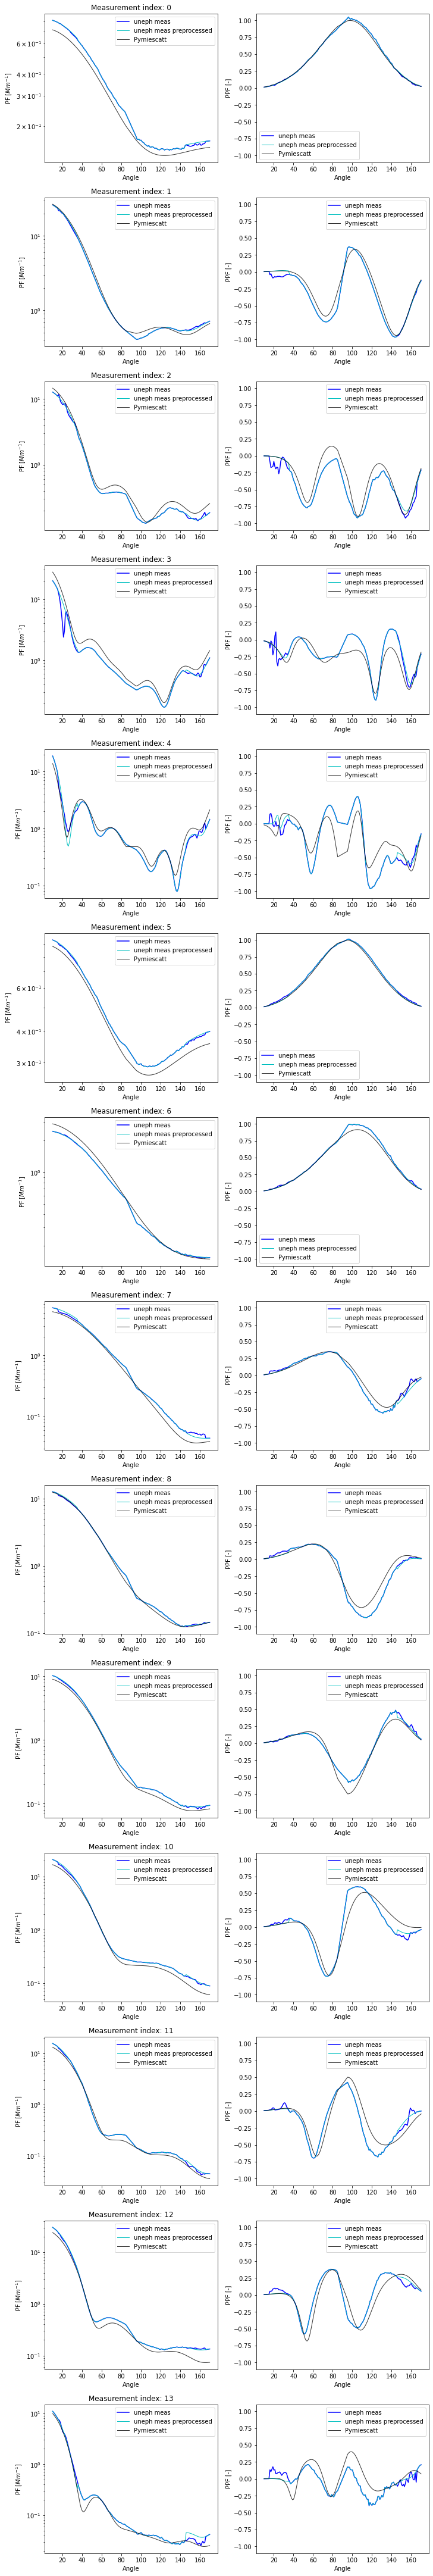

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)
for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements.jpg')


In [14]:
qoi_meas

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.204740     -0.209146     -0.213989     -0.219270     -0.224985   
1       3.258521      3.241076      3.221874      3.200914      3.178192   
2       2.544908      2.521328      2.495335      2.466914      2.436046   
3       2.990300      2.937681      2.879486      2.815629      2.746023   
4       2.931774      2.825154      2.704960      2.570127      2.419358   
5      -0.066951     -0.070802     -0.075036     -0.079651     -0.084645   
6       0.894826      0.889829      0.884335      0.878346      0.871861   
7       1.795814      1.787932      1.779266      1.769816      1.759584   
8       2.532329      2.522532      2.511755      2.499998      2.487260   
9       2.322878      2.310996      2.297923      2.283657      2.268199   
10      3.039288      3.022321      3.003637      2.983234      2.961104   
11      2.748592      2.725912      2.700913      2.673579      2.643893   
12      3.407141      3.376834      3.343389      3.306776      3.266958   
13      2.392022      2.339699      2.281746      2.218038      2.148435   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.231135     -0.238678     -0.247405     -0.250614     -0.257544  ...   
1       3.153705      3.085057      3.079462      3.058732      3.015831  ...   
2       2.402714      2.460123      2.361134      2.213312      2.163275  ...   
3       2.670581      2.528389      2.344447      2.093368      1.753163  ...   
4       2.251073      1.745113      1.527188      1.370891      1.182549  ...   
5      -0.090018     -0.104577     -0.114813     -0.120207     -0.121156  ...   
6       0.864882      0.861694      0.855720      0.845499      0.832738  ...   
7       1.748572      1.647445      1.628860      1.612596      1.597519  ...   
8       2.473543      2.406455      2.388337      2.377311      2.366132  ...   
9       2.251546      2.210759      2.194205      2.171341      2.145541  ...   
10      2.937241      2.833671      2.811790      2.797430      2.768145  ...   
11      2.611837      2.534591      2.504700      2.456799      2.404771  ...   
12      3.223898      3.146513      3.119785      3.031482      2.951414  ...   
13      2.072779      2.013089      1.976454      1.868523      1.688723  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141       -0.50454      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497        0.06563       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791        0.03127   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364       -0.03792      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.044564       0.038592       0.033057       0.027956       0.023287  
1       -0.249522      -0.216496      -0.185668      -0.157119      -0.130907  
2       -0.396607      -0.344951       -0.29593      -0.250108      -0.207876  
3       -0.412606      -0.357914      -0.305482      -0.256474      -0.211591  
4       -0.356307      -0.29674

In [15]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.204740     -0.209146     -0.213989     -0.219270     -0.224985   
1       3.258521      3.241076      3.221874      3.200914      3.178192   
2       2.544908      2.521328      2.495335      2.466914      2.436046   
3       2.990300      2.937681      2.879486      2.815629      2.746023   
4       2.931774      2.825154      2.704960      2.570127      2.419358   
5      -0.066951     -0.070802     -0.075036     -0.079651     -0.084645   
6       0.894826      0.889829      0.884335      0.878346      0.871861   
7       1.795814      1.787932      1.779266      1.769816      1.759584   
8       2.532329      2.522532      2.511755      2.499998      2.487260   
9       2.322878      2.310996      2.297923      2.283657      2.268199   
10      3.039288      3.022321      3.003637      2.983234      2.961104   
11      2.748592      2.725912      2.700913      2.673579      2.643893   
12      3.407141      3.376834      3.343389      3.306776      3.266958   
13      2.392022      2.339699      2.281746      2.218038      2.148435   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.231135     -0.237719     -0.244734     -0.252179     -0.260053  ...   
1       3.153705      3.127450      3.099424      3.069623      3.038046  ...   
2       2.402714      2.366895      2.328568      2.287708      2.244290  ...   
3       2.670581      2.589217      2.501855      2.408434      2.308918  ...   
4       2.251073      2.063347      1.853838      1.619727      1.357727  ...   
5      -0.090018     -0.095768     -0.101893     -0.108393     -0.115265  ...   
6       0.864882      0.857410      0.849447      0.840992      0.832049  ...   
7       1.748572      1.736781      1.724212      1.710867      1.696749  ...   
8       2.473543      2.458845      2.443167      2.426509      2.408871  ...   
9       2.251546      2.233699      2.214654      2.194413      2.172973  ...   
10      2.937241      2.911639      2.884291      2.855187      2.824322  ...   
11      2.611837      2.577391      2.540532      2.501238      2.459483  ...   
12      3.223898      3.177552      3.127875      3.074815      3.018316  ...   
13      2.072779      1.990892      1.902572      1.807597      1.705716  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.081034       0.072851       0.065115       0.057823       0.050974   
1       -0.442524      -0.400883      -0.360518      -0.321694      -0.284636   
2       -0.660275      -0.611036      -0.558628      -0.504535       -0.45013   
3       -0.638159      -0.609828       -0.56966      -0.521175      -0.467822   
4       -0.580507      -0.558302      -0.522558      -0.474301      -0.417153   
5        0.068454       0.061512       0.054955        0.04878       0.042984   
6        0.117186       0.105547       0.094501       0.084052       0.074205   
7       -0.167922      -0.151881      -0.136464      -0.121726      -0.107716   
8        0.011969       0.013367       0.014146       0.014395         0.0142   
9        0.192151       0.175165       0.158521       0.142335       0.126713   
10      -0.087538      -0.083462      -0.078723      -0.073427      -0.067688   
11      -0.050779      -0.041434      -0.032962      -0.025375      -0.018693   
12       0.166831       0.153275       0.139661       0.126198       0.113069   
13       0.040776        0.05445       0.071118        0.09077         0.1131   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.044564       0.038592       0.033057       0.027956       0.023287  
1       -0.249522      -0.216496      -0.185668      -0.157119      -0.130907  
2       -0.396607      -0.344951       -0.29593      -0.250108      -0.207876  
3       -0.412606      -0.357914      -0.305482      -0.256474      -0.211591  
4       -0.356307      -0.29674

In [16]:
qoi_meas_pymiescatt

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.330722 -0.335406 -0.340532 -0.346100 -0.352109 -0.358556 -0.365442   
1   3.279742  3.262431  3.243463  3.222838  3.200552  3.176605  3.150995   
2   2.681297  2.656183  2.628618  2.598585  2.566067  2.531043  2.493492   
3   3.316615  3.261761  3.201326  3.135219  3.063343  2.985599  2.901892   
4   2.626295  2.509020  2.377339  2.230161  2.066209  1.884021  1.681980   
5  -0.126536 -0.130674 -0.135202 -0.140119 -0.145425 -0.151117 -0.157195   
6   1.057597  1.052010  1.045895  1.039251  1.032082  1.024387  1.016169   
7   1.647584  1.639660  1.630986  1.621563  1.611393  1.600476  1.588815   
8   2.512474  2.502008  2.490545  2.478086  2.464630  2.450179  2.434731   
9   2.191082  2.179161  2.166100  2.151899  2.136556  2.120069  2.102438   
10  2.817757  2.801281  2.783222  2.763577  2.742340  2.719508  2.695075   
11  2.576809  2.554683  2.530408  2.503972  2.475362  2.444564  2.411563   
12  3.176521  3.147132  3.114848  3.079640  3.041478  3.000329  2.956156   
13  2.287451  2.235916  2.179083  2.116835  2.049042  1.975553  1.896204   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  -0.372765 -0.380522 -0.388714  ...  0.075290  0.067477  0.060104  0.053171   
1   3.123719  3.094777  3.064166  ... -0.426074 -0.384111 -0.343685 -0.305037   
2   2.453391  2.410716  2.365439  ... -0.638724 -0.584372 -0.528777 -0.473179   
3   2.812132  2.716245  2.614180  ... -0.659852 -0.611053 -0.555606 -0.496657   
4   1.458435  1.212017  0.942395  ... -0.690478 -0.659288 -0.610779 -0.549424   
5  -0.163656 -0.170499 -0.177722  ...  0.064931  0.058182  0.051817  0.045832   
6   1.007428  0.998166  0.988385  ...  0.105330  0.094565  0.084371  0.074750   
7   1.576411  1.563266  1.549383  ... -0.108208 -0.095673 -0.084043 -0.073306   
8   2.418287  2.400848  2.382413  ...  0.047522  0.044453  0.041145  0.037672   
9   2.083660  2.063735  2.042660  ...  0.165475  0.150214  0.135351  0.120977   
10  2.669038  2.641389  2.612124  ... -0.001929 -0.003679 -0.004958 -0.005815   
11  2.376343  2.338885  2.299171  ... -0.171137 -0.153189 -0.135917 -0.119461   
12  2.908920  2.858577  2.805079  ...  0.218257  0.202657  0.186377  0.169658   
13  1.810808  1.719155  1.621013  ...  0.119823  0.123663  0.124947  0.123646   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.046673  0.040608  0.034975  0.029769  0.024990  0.020634  
1  -0.268364 -0.233820 -0.201520 -0.171547 -0.143958 -0.118788  
2  -0.418641 -0.366030 -0.316024 -0.269131 -0.225709 -0.185992  
3  -0.436943 -0.378629 -0.323275 -0.271903 -0.225094 -0.183102  
4  -0.480965 -0.410948 -0.343714 -0.282059 -0.227385 -0.180077  
5   0.040226  0.034994  0.030136  0.025648  0.021529  0.017775  
6   0.065706  0.057241  0.049357  0.042055  0.035337  0.029202  
7  -0.063444 -0.054432 -0.046241 -0.038838 -0.032189 -0.026258  
8   0.034104  0.030503  0.026928  0.023431  0.020058  0.016851  
9   0.107174  0.094014  0.081560  0.069867  0.058980  0.048939  
10 -0.006301 -0.006468 -0.006367 -0.006051 -0.005569 -0.004967  
11 -0.103941 -0.089454 -0.076073 -0.063843 -0.052787 -0.042903  
12  0.152746  0.135886  0.119318  0.103261  0.087918  0.073464  
13  0.119858  0.113797  0.105778  0.096195  0.085485  0.074104  

[14 rows x 304 columns]

# Make predictions with the forward model fw
## from phase functions to aerosol properties

In [17]:
# prediction of measurement data
dvar_meas_pred = surr_fw.predict(qoi_meas[F11_columns_meas].values)
dvar_meas_pred = pd.DataFrame(data =dvar_meas_pred, columns = dvar_meas.columns)
dvar_meas_pred_2qoi = dvar_meas_pred.copy()
dvar_meas_pred = np.exp(dvar_meas_pred)
dvar_meas_pred['GSD']=dvar_meas_pred['GSD']+1
dvar_meas_pred['n']=dvar_meas_pred['n']+1.33
dvar_meas_pred['RmedianV'] = dvar_meas_pred['RmedianV']*1e-3 # in um
dvar_meas_pred.to_csv(f'{plot_dir}/dvar_meas_pred.csv')
dvar_meas_pred

Vtot  RmedianV       GSD         n         k
0   0.692928  0.103133  1.046253  1.577543  0.052513
1   6.981959  0.242798  1.024694  2.289171  0.170027
2   2.409571  0.308799  1.068984  1.416644  0.214368
3   2.751028  0.404478  1.130453  1.506068  0.007206
4   3.605236  0.430910  1.029060  1.535477  0.029357
5   0.248425  0.134975  1.013786  3.027802  0.130315
6   1.921604  0.119366  1.071803  1.606449  0.351514
7   4.964739  0.163646  1.074166  1.372056  0.301852
8   6.080655  0.189917  1.176867  1.486292  0.482252
9   2.118257  0.208439  1.085959  1.631169  0.200488
10  5.412558  0.245033  1.086455  1.684625  0.344841
11  3.093291  0.295041  1.075009  1.569814  0.150126
12  6.758318  0.330258  1.089746  1.581829  0.414617
13  2.758581  0.457968  1.126336  1.627162  0.159282

In [18]:
dvar_meas_pred_2qoi

Vtot  RmedianV       GSD         n         k
0  -0.366829  4.636023 -3.073625 -1.396171 -2.946695
1   1.943330  5.492228 -3.701177 -0.041686 -1.771799
2   0.879449  5.732690 -2.673880 -2.445947 -1.540061
3   1.011975  6.002596 -2.036741 -1.736888 -4.932863
4   1.282387  6.065900 -3.538383 -1.582420 -3.528210
5  -1.392616  4.905089 -4.284071  0.529335 -2.037797
6   0.653160  4.782197 -2.633825 -1.285729 -1.045507
7   1.602361  5.097704 -2.601449 -3.168741 -1.197820
8   1.805112  5.246587 -1.732355 -1.856032 -0.729288
9   0.750594  5.339646 -2.453889 -1.200084 -1.606999
10  1.688722  5.501393 -2.448130 -1.036694 -1.064671
11  1.129236  5.687115 -2.590142 -1.427893 -1.896280
12  1.910774  5.799875 -2.410767 -1.379004 -0.880400
13  1.014716  6.126800 -2.068813 -1.213477 -1.837079

In [19]:
# prediction of processed measurement data
dvar_meas_preprocessed_pred = surr_fw.predict(qoi_meas_preprocessed[F11_columns_meas].values)
dvar_meas_preprocessed_pred = pd.DataFrame(data =dvar_meas_preprocessed_pred, columns = dvar_meas.columns)
dvar_meas_preprocessed_pred_2qoi = dvar_meas_preprocessed_pred.copy()
dvar_meas_preprocessed_pred = np.exp(dvar_meas_preprocessed_pred)
dvar_meas_preprocessed_pred['GSD']=dvar_meas_preprocessed_pred['GSD']+1
dvar_meas_preprocessed_pred['n']=dvar_meas_preprocessed_pred['n']+1.33
dvar_meas_preprocessed_pred['RmedianV'] = dvar_meas_preprocessed_pred['RmedianV']*1e-3 # in um
dvar_meas_preprocessed_pred.to_csv(f'{plot_dir}/dvar_meas_preprocessed_pred.csv')
dvar_meas_preprocessed_pred

Vtot  RmedianV       GSD         n         k
0   0.653097  0.103658  1.043427  1.593986  0.043395
1   7.096619  0.239539  1.024320  2.397839  0.153224
2   2.483256  0.309668  1.054628  1.400859  0.233038
3   1.731082  0.327544  1.076393  1.638771  0.011959
4   2.151510  0.300073  1.031565  1.596235  0.065319
5   0.242991  0.129135  1.014369  2.569541  0.230951
6   2.035025  0.122027  1.066309  1.565635  0.296680
7   2.714338  0.152952  1.098109  1.738960  0.358586
8   5.546627  0.178624  1.197154  1.516335  0.463873
9   2.089442  0.196524  1.090383  1.621563  0.216375
10  5.225222  0.237035  1.085910  1.711072  0.364314
11  3.217746  0.292289  1.059871  1.551283  0.168231
12  6.889522  0.324255  1.084188  1.561266  0.494035
13  2.782638  0.487503  1.107323  1.648797  0.117559

In [20]:
F11_columns = [x for x in qoi_meas_pymiescatt.columns if 'F11' in x]

In [21]:
# prediction of with pymiescatt predicted measurement data
dvar_meas_pymiescatt_pred = surr_fw.predict(qoi_meas_pymiescatt[F11_columns].values)
dvar_meas_pymiescatt_pred = pd.DataFrame(data =dvar_meas_pymiescatt_pred, columns = dvar_meas.columns)
dvar_meas_pymiescatt_pred_2qoi = dvar_meas_pymiescatt_pred.copy()

dvar_meas_pymiescatt_pred = np.exp(dvar_meas_pymiescatt_pred)
dvar_meas_pymiescatt_pred['GSD']=dvar_meas_pymiescatt_pred['GSD']+1
dvar_meas_pymiescatt_pred['n']=dvar_meas_pymiescatt_pred['n']+1.33
dvar_meas_pymiescatt_pred['RmedianV'] = dvar_meas_pymiescatt_pred['RmedianV']*1e-3 # in um
dvar_meas_pymiescatt_pred.to_csv(f'{plot_dir}/dvar_meas_pymiescatt_pred.csv')
dvar_meas_pymiescatt_pred

Vtot  RmedianV       GSD         n         k
0   0.589825  0.113698  1.028267  1.683195  0.046806
1   4.349732  0.223454  1.034784  2.962148  0.016825
2   2.624478  0.311495  1.044638  1.446425  0.124222
3   2.627843  0.307941  1.133637  1.554768  0.010452
4   1.445653  0.445681  1.060582  1.349585  0.002971
5   0.246542  0.145020  1.009142  3.446233  0.045939
6   1.953048  0.118785  1.104455  1.731712  0.418190
7   3.174106  0.153197  1.080026  1.591317  0.302958
8   5.018433  0.181102  1.126974  1.557372  0.517100
9   1.801750  0.210248  1.042938  1.664679  0.241595
10  4.249486  0.239323  1.071803  1.624116  0.281137
11  2.997876  0.267463  1.077000  1.677084  0.175091
12  4.350527  0.306527  1.080594  1.640431  0.258556
13  2.429014  0.471726  1.076269  1.665897  0.218753

# Make predictions with the forward model iv
## from aerosol properties to phase functions

In [22]:
dvar_meas_2qoi = dvar_meas.copy()
dvar_meas_2qoi['RmedianV']= dvar_meas_2qoi['RmedianV']*1e3
dvar_meas_2qoi['GSD']= dvar_meas_2qoi['GSD']-1
dvar_meas_2qoi['n']= dvar_meas_2qoi['n']-1.33
dvar_meas_2qoi = np.log(dvar_meas_2qoi.astype('float64'))
dvar_meas_2qoi


Vtot  RmedianV       GSD         n         k
0  -0.170104  4.609785 -3.218876 -1.347074 -9.210340
1   1.130124  5.528602 -2.995732 -1.347074 -9.210340
2   0.316112  5.710924 -2.995732 -1.347074 -9.210340
3   1.259201  5.998606 -2.995732 -1.347074 -9.210340
4   1.560907  6.221750 -2.995732 -1.347074 -9.210340
5   0.797529  4.339768 -2.407946 -1.237874 -1.500584
6   0.733104  4.767212 -2.407946 -1.237874 -1.500584
7   0.764918  5.028404 -2.525729 -1.237874 -1.500584
8   1.354122  5.182555 -2.525729 -1.237874 -1.500584
9   0.901635  5.260757 -2.659260 -1.237874 -1.500584
10  1.327906  5.433869 -2.525729 -1.237874 -1.500584
11  0.973193  5.578451 -2.525729 -1.237874 -1.500584
12  1.529973  5.717516 -2.659260 -1.237874 -1.500584
13  0.708613  5.986968 -2.302585 -1.237874 -1.500584

In [23]:
F11_columns

['F11_10',
 'F11_11',
 'F11_12',
 'F11_13',
 'F11_14',
 'F11_15',
 'F11_16',
 'F11_17',
 'F11_18',
 'F11_19',
 'F11_20',
 'F11_21',
 'F11_22',
 'F11_23',
 'F11_24',
 'F11_25',
 'F11_26',
 'F11_27',
 'F11_28',
 'F11_29',
 'F11_30',
 'F11_31',
 'F11_32',
 'F11_33',
 'F11_34',
 'F11_35',
 'F11_36',
 'F11_37',
 'F11_38',
 'F11_39',
 'F11_40',
 'F11_41',
 'F11_42',
 'F11_43',
 'F11_44',
 'F11_45',
 'F11_46',
 'F11_47',
 'F11_48',
 'F11_49',
 'F11_50',
 'F11_51',
 'F11_52',
 'F11_53',
 'F11_54',
 'F11_55',
 'F11_56',
 'F11_57',
 'F11_58',
 'F11_59',
 'F11_60',
 'F11_61',
 'F11_62',
 'F11_63',
 'F11_64',
 'F11_65',
 'F11_66',
 'F11_67',
 'F11_68',
 'F11_69',
 'F11_70',
 'F11_71',
 'F11_72',
 'F11_73',
 'F11_74',
 'F11_75',
 'F11_76',
 'F11_77',
 'F11_78',
 'F11_79',
 'F11_80',
 'F11_81',
 'F11_82',
 'F11_83',
 'F11_84',
 'F11_85',
 'F11_95',
 'F11_96',
 'F11_97',
 'F11_98',
 'F11_99',
 'F11_100',
 'F11_101',
 'F11_102',
 'F11_103',
 'F11_104',
 'F11_105',
 'F11_106',
 'F11_107',
 'F11_108',
 

In [24]:
# qoi: prediction of true data
qoi_pred = surr_iv.predict(dvar_meas_2qoi)
qoi_pred = pd.DataFrame(qoi_pred, columns = F11_columns)
qoi_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_pred


F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   0.536111  0.543204  0.678869  0.508947  0.247735  0.216790  0.174826   
1   2.930939  2.719515  2.570758  2.489309  2.371101  2.321816  2.182143   
2   1.816613  1.725115  1.617028  1.520471  1.396402  1.348294  1.228042   
3   2.512165  2.404505  2.325741  2.303071  2.260136  2.129239  1.937064   
4   2.676068  2.529430  2.493513  2.553867  2.549885  2.352334  2.096094   
5   0.444359  0.427332  0.400790  0.352783  0.356614  0.305558  0.284007   
6   1.020697  1.039310  1.040021  1.022538  1.001972  0.978450  0.966733   
7   1.626902  1.637953  1.622070  1.601381  1.588500  1.557865  1.539060   
8   2.421772  2.419258  2.403186  2.385315  2.389108  2.371770  2.363798   
9   2.114687  2.092861  2.079768  2.067261  2.078942  2.058838  2.052044   
10  2.790743  2.776558  2.757125  2.729390  2.714506  2.671990  2.646024   
11  2.541891  2.534435  2.496219  2.452229  2.415224  2.404363  2.377834   
12  3.128945  3.094320  3.054874  3.027391  2.982486  2.975975  2.932086   
13  2.325157  2.268237  2.216332  2.153697  2.080724  1.989402  1.899023   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0   0.336896  0.478650  0.568842  ... -0.703701 -0.738059 -0.810990 -0.914518   
1   2.110607  2.131616  2.031809  ... -1.252522 -1.191810 -1.225299 -1.196940   
2   1.176639  1.193188  1.112036  ... -1.404010 -1.303270 -1.328842 -1.295684   
3   1.837451  1.759981  1.589619  ...  0.254453  0.460842  0.446212  0.568444   
4   1.936864  1.749228  1.550070  ...  0.381044  0.644667  0.639281  0.802302   
5   0.314818  0.304475  0.345834  ... -0.239453 -0.228058 -0.180864 -0.149085   
6   0.967984  0.964914  0.969455  ... -1.861654 -1.863334 -1.871434 -1.877902   
7   1.524578  1.507977  1.502734  ... -3.339026 -3.341708 -3.353761 -3.356095   
8   2.349278  2.335479  2.331882  ... -2.078063 -2.064808 -2.064914 -2.051467   
9   2.035819  2.017719  2.033047  ... -2.713255 -2.708325 -2.706308 -2.714830   
10  2.628811  2.606108  2.602707  ... -2.670117 -2.673438 -2.672929 -2.698972   
11  2.354586  2.314910  2.249837  ... -3.218342 -3.235543 -3.241346 -3.260112   
12  2.881262  2.831054  2.752362  ... -2.671536 -2.709330 -2.722998 -2.727945   
13  1.810999  1.733274  1.662040  ... -3.695910 -3.710242 -3.740735 -3.754735   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -0.694774 -0.987555 -0.823602 -0.941046 -0.949576 -0.971504  
1  -1.232294 -1.214134 -1.268618 -1.308364 -1.336536 -1.327777  
2  -1.299253 -1.287560 -1.338901 -1.390197 -1.411530 -1.412494  
3   0.595750  0.639145  0.681209  0.648912  0.725108  0.760267  
4   0.882443  0.954997  1.059413  1.058462  1.210386  1.273822  
5  -0.215480 -0.235757 -0.215183 -0.192294 -0.235715 -0.174167  
6  -1.875312 -1.884074 -1.883803 -1.887846 -1.882826 -1.888817  
7  -3.355598 -3.366333 -3.371401 -3.372794 -3.360884 -3.367613  
8  -2.035764 -2.031809 -2.022503 -2.021859 -1.983710 -1.977511  
9  -2.708278 -2.716763 -2.704285 -2.702266 -2.679900 -2.681417  
10 -2.700593 -2.720933 -2.717057 -2.713276 -2.724110 -2.724367  
11 -3.264745 -3.273513 -3.276354 -3.276611 -3.303845 -3.297193  
12 -2.752731 -2.757525 -2.768125 -2.777012 -2.807771 -2.817968  
13 -3.771511 -3.784524 -3.789467 -3.804404 -3.779898 -3.793987  

[14 rows x 152 columns]

In [25]:
# qoi: prediction of measurement data

qoi_meas_pred = surr_iv.predict(dvar_meas_pred_2qoi)
qoi_meas_pred = pd.DataFrame(qoi_meas_pred, columns = F11_columns)
qoi_meas_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_meas_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.339484 -0.429414 -0.394799 -0.315131 -0.204204 -0.193901 -0.203075   
1   2.994079  2.987132  2.976903  2.948494  2.879334  2.849051  2.795149   
2   2.287150  2.277440  2.235471  2.191863  2.131204  2.135580  2.087752   
3   3.300660  3.259957  3.206360  3.144257  3.069598  2.995447  2.919913   
4   3.441587  3.418619  3.306355  3.208008  3.124737  3.045650  2.989816   
5   0.130424  0.196238  0.148455 -0.007453 -0.098060 -0.153940 -0.130654   
6   0.903250  0.914789  0.911546  0.890409  0.867553  0.846289  0.835677   
7   1.922190  1.919386  1.909962  1.895042  1.887361  1.868935  1.858944   
8   2.591850  2.592477  2.583299  2.562328  2.545780  2.527458  2.517438   
9   2.169708  2.145618  2.129610  2.111588  2.114546  2.082268  2.068610   
10  3.094636  3.096322  3.069691  3.027745  2.987174  2.951276  2.919156   
11  2.853874  2.842312  2.798577  2.760172  2.715129  2.721017  2.691796   
12  3.358966  3.330489  3.282582  3.239544  3.197977  3.157255  3.110239   
13  2.645568  2.581852  2.473211  2.343814  2.246657  2.165155  2.088014   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0  -0.209327 -0.289104 -0.267151  ... -1.955704 -1.923516 -1.905432 -1.844021   
1   2.770396  2.753789  2.702506  ... -0.559697 -0.533447 -0.504083 -0.470538   
2   2.047040  1.995532  1.883091  ... -3.858125 -3.884190 -3.884021 -3.883453   
3   2.852214  2.788518  2.716428  ... -1.079010 -1.089431 -1.115567 -1.119335   
4   2.926565  2.848185  2.672080  ... -1.192088 -1.210026 -1.189853 -1.147749   
5  -0.081315 -0.046170 -0.038300  ... -1.385187 -1.302954 -1.278225 -1.270184   
6   0.832705  0.829781  0.836705  ... -1.955327 -1.960141 -1.972638 -1.983761   
7   1.844417  1.835898  1.825811  ... -3.125790 -3.119026 -3.122115 -3.112354   
8   2.506780  2.487630  2.467682  ... -1.780024 -1.776894 -1.770869 -1.769640   
9   2.050455  2.029851  2.036744  ... -3.059182 -3.061362 -3.065629 -3.084952   
10  2.900163  2.869957  2.837421  ... -2.250547 -2.250562 -2.251780 -2.262421   
11  2.649773  2.594082  2.486108  ... -3.000192 -3.047808 -3.063364 -3.072658   
12  3.055323  2.983851  2.924898  ... -2.333660 -2.340652 -2.338830 -2.341785   
13  1.999126  1.865348  1.701739  ... -3.216670 -3.238896 -3.263263 -3.284037   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -1.898308 -1.944291 -1.877297 -1.870716 -1.883359 -1.820834  
1  -0.434335 -0.393927 -0.382660 -0.378631 -0.395290 -0.362299  
2  -3.890065 -3.873502 -3.893966 -3.894900 -3.932840 -3.919876  
3  -1.129266 -1.124593 -1.120328 -1.104504 -1.073791 -1.028743  
4  -1.123241 -1.091396 -1.076983 -1.017992 -1.002528 -0.897431  
5  -1.219034 -1.207238 -1.193200 -1.194768 -1.222848 -1.122001  
6  -1.982963 -1.995739 -1.998581 -2.009511 -1.999823 -2.014444  
7  -3.101294 -3.096096 -3.090253 -3.086398 -3.059701 -3.051416  
8  -1.764278 -1.764019 -1.758374 -1.753230 -1.748667 -1.740530  
9  -3.087483 -3.104754 -3.100479 -3.101608 -3.091636 -3.097749  
10 -2.258214 -2.260659 -2.254977 -2.247140 -2.252351 -2.243804  
11 -3.103545 -3.108764 -3.126993 -3.143459 -3.185410 -3.192092  
12 -2.343956 -2.341703 -2.341178 -2.339816 -2.343709 -2.348658  
13 -3.305927 -3.309007 -3.319128 -3.342961 -3.324350 -3.321000  

[14 rows x 152 columns]

In [26]:
# qoi: prediction of processed measurement data

qoi_meas_preprocessed_pred = surr_iv.predict(dvar_meas_preprocessed_pred_2qoi)
qoi_meas_preprocessed_pred = pd.DataFrame(qoi_meas_preprocessed_pred, columns = F11_columns)
qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/qoi_meas_preprocessed_pred.csv')
qoi_meas_preprocessed_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.253882 -0.379153 -0.338655 -0.253124 -0.110728 -0.102943 -0.113160   
1   3.033683  3.025804  3.012918  2.992098  2.933065  2.909148  2.854089   
2   2.263320  2.249905  2.207810  2.164375  2.102498  2.107895  2.059379   
3   2.635197  2.623560  2.610536  2.579056  2.496678  2.424563  2.357377   
4   2.682825  2.672453  2.664582  2.671787  2.625087  2.610317  2.578246   
5   0.426939  0.413943  0.456567  0.295557  0.197165  0.167399  0.141754   
6   0.916414  0.927897  0.925252  0.905110  0.878331  0.855936  0.841211   
7   1.959532  1.968385  1.953817  1.940850  1.931258  1.910727  1.900500   
8   2.452255  2.456773  2.451526  2.433253  2.415841  2.396121  2.385168   
9   1.993112  1.974807  1.961457  1.944364  1.950004  1.923214  1.912223   
10  3.030974  3.034085  3.013760  2.975607  2.935353  2.893996  2.861755   
11  2.841632  2.829016  2.788701  2.751626  2.704548  2.707999  2.674507   
12  3.313690  3.291297  3.242871  3.197171  3.156715  3.123572  3.081391   
13  2.536490  2.476346  2.385576  2.272268  2.166208  2.072880  1.972124   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0  -0.135414 -0.227101 -0.200777  ... -1.890298 -1.834678 -1.813591 -1.741456   
1   2.825655  2.808334  2.750936  ... -0.526465 -0.496804 -0.471154 -0.431372   
2   2.018874  1.964854  1.856237  ... -3.957822 -3.985651 -3.979136 -3.981210   
3   2.309948  2.282539  2.225662  ... -0.976979 -0.967149 -0.929875 -0.890290   
4   2.541220  2.496943  2.450508  ... -2.351731 -2.407573 -2.384941 -2.381607   
5   0.233622  0.203899  0.279558  ... -1.670385 -1.678287 -1.604589 -1.613038   
6   0.837776  0.834970  0.840302  ... -2.171929 -2.175438 -2.188012 -2.197231   
7   1.889199  1.871528  1.860772  ... -2.767712 -2.774495 -2.785365 -2.787749   
8   2.373530  2.358925  2.347109  ... -1.886902 -1.885703 -1.881522 -1.881620   
9   1.895669  1.877286  1.885671  ... -2.877754 -2.871757 -2.871616 -2.878426   
10  2.843666  2.818795  2.796168  ... -2.087143 -2.089017 -2.091664 -2.104013   
11  2.632528  2.578726  2.481699  ... -3.157893 -3.208376 -3.220588 -3.238566   
12  3.032067  2.959819  2.895030  ... -2.212335 -2.218946 -2.214474 -2.217899   
13  1.855538  1.698315  1.516642  ... -2.887277 -2.895358 -2.901569 -2.902810   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -1.809446 -1.866724 -1.790821 -1.778260 -1.787115 -1.698548  
1  -0.394545 -0.350478 -0.339891 -0.337023 -0.348736 -0.316788  
2  -3.986057 -3.966937 -3.982527 -3.974143 -4.014381 -3.997623  
3  -0.874407 -0.840136 -0.815750 -0.762512 -0.769290 -0.711127  
4  -2.416832 -2.408262 -2.410831 -2.383472 -2.450581 -2.445963  
5  -1.488905 -1.532076 -1.455378 -1.439315 -1.463129 -1.401676  
6  -2.197058 -2.208283 -2.209050 -2.217341 -2.209671 -2.220388  
7  -2.796194 -2.805008 -2.812071 -2.818615 -2.814329 -2.824820  
8  -1.878364 -1.880349 -1.876217 -1.873984 -1.872195 -1.867043  
9  -2.871153 -2.878634 -2.869699 -2.869665 -2.845904 -2.847191  
10 -2.104909 -2.111950 -2.108174 -2.103512 -2.110815 -2.107448  
11 -3.269919 -3.277750 -3.297867 -3.310665 -3.361740 -3.367888  
12 -2.217874 -2.217148 -2.216573 -2.213689 -2.218827 -2.222536  
13 -2.909308 -2.890962 -2.886688 -2.893581 -2.865982 -2.838724  

[14 rows x 152 columns]

In [27]:
# qoi: prediction of with pymiescatt predicted measurement data

qoi_meas_pymiescatt_pred=surr_iv.predict(dvar_meas_pymiescatt_pred_2qoi)
qoi_meas_pymiescatt_pred = pd.DataFrame(qoi_meas_pymiescatt_pred, columns = F11_columns)
qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/qoi_meas_pymiescatt_pred.csv')
qoi_meas_pymiescatt_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.044766 -0.211840 -0.178758 -0.108523  0.004129  0.048416  0.038225   
1   2.957869  2.948780  2.949779  2.897597  2.821089  2.809783  2.831110   
2   2.624765  2.598840  2.568664  2.551240  2.505093  2.502735  2.454467   
3   3.260347  3.257002  3.235256  3.188171  3.129824  3.085321  3.040072   
4   2.811373  2.772222  2.720631  2.635768  2.564349  2.557292  2.508291   
5  -0.109759  0.011277 -0.010489 -0.318071 -0.487561 -0.503463 -0.439383   
6   1.177791  1.185812  1.184759  1.168890  1.151767  1.131705  1.122142   
7   1.899882  1.912868  1.900386  1.881745  1.867399  1.838037  1.821826   
8   2.436146  2.433804  2.419080  2.395966  2.389225  2.374635  2.372367   
9   2.035241  2.013389  2.005022  1.992087  1.988092  1.945338  1.929347   
10  2.865932  2.856037  2.830080  2.792233  2.767427  2.732525  2.705727   
11  2.759906  2.751974  2.713485  2.669200  2.631958  2.626335  2.608443   
12  3.029037  2.988694  2.949111  2.921263  2.875990  2.864255  2.812261   
13  2.365248  2.313535  2.220874  2.102288  2.009348  1.924462  1.848205   

      F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0   0.007661 -0.076519 -0.044967  ... -2.544915 -2.529163 -2.515980 -2.487128   
1   2.781276  2.789095  2.842552  ...  0.227308  0.258810  0.322745  0.293284   
2   2.401503  2.352652  2.274340  ... -3.603732 -3.660156 -3.662043 -3.677412   
3   3.004138  2.953103  2.899756  ... -1.367223 -1.360429 -1.344577 -1.319324   
4   2.445952  2.435678  2.348716  ... -3.143210 -3.191080 -3.207417 -3.183765   
5  -0.349142 -0.293818 -0.275753  ... -3.435743 -3.398543 -3.435845 -3.581258   
6   1.116380  1.111116  1.112999  ... -1.728228 -1.734430 -1.743633 -1.753060   
7   1.805505  1.793450  1.787696  ... -3.122742 -3.128627 -3.142043 -3.146585   
8   2.363013  2.343055  2.326806  ... -1.805159 -1.797755 -1.794272 -1.790540   
9   1.910322  1.894595  1.920772  ... -3.234686 -3.246033 -3.245261 -3.278455   
10  2.691065  2.667940  2.652906  ... -2.614775 -2.613484 -2.606077 -2.629856   
11  2.584399  2.541316  2.466790  ... -2.822401 -2.848825 -2.855788 -2.874205   
12  2.758213  2.706521  2.631167  ... -2.663251 -2.689214 -2.698678 -2.694747   
13  1.751973  1.605132  1.439914  ... -3.725541 -3.740521 -3.755482 -3.769336   

     F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0  -2.522278 -2.591912 -2.543095 -2.561196 -2.546760 -2.516674  
1   0.332472  0.371555  0.345081  0.398704  0.412875  0.393755  
2  -3.717176 -3.714447 -3.744069 -3.755847 -3.819866 -3.829367  
3  -1.282074 -1.244829 -1.198322 -1.138310 -1.088210 -1.025155  
4  -3.170170 -3.158445 -3.181693 -3.150344 -3.156273 -3.116854  
5  -3.485731 -3.542817 -3.631757 -3.635700 -3.674696 -3.621414  
6  -1.751499 -1.761997 -1.764639 -1.771382 -1.767103 -1.776979  
7  -3.149871 -3.162278 -3.170823 -3.172194 -3.166285 -3.173686  
8  -1.782820 -1.782164 -1.776083 -1.773431 -1.754675 -1.750166  
9  -3.295679 -3.323992 -3.319419 -3.315635 -3.335007 -3.344270  
10 -2.624295 -2.633705 -2.628295 -2.616330 -2.634207 -2.621182  
11 -2.885447 -2.899425 -2.899385 -2.900336 -2.932021 -2.927191  
12 -2.710212 -2.705879 -2.709200 -2.714583 -2.731765 -2.738827  
13 -3.778868 -3.781857 -3.781499 -3.791394 -3.767331 -3.756424  

[14 rows x 152 columns]

In [28]:
np.exp(qoi_meas_pred)

F11_10     F11_11     F11_12     F11_13     F11_14     F11_15  \
0    0.712138   0.650891   0.673815   0.729693   0.815296   0.823740   
1   19.966955  19.828741  19.626928  19.077194  17.802417  17.271387   
2    9.846837   9.751682   9.350882   8.951875   8.425007   8.461953   
3   27.130538  26.048422  24.689064  23.202436  21.533236  19.994285   
4   31.236480  30.527219  27.285475  24.729782  22.753902  21.023700   
5    1.139312   1.216817   1.160040   0.992575   0.906594   0.857324   
6    2.467609   2.496250   2.488167   2.436126   2.381078   2.330981   
7    6.835913   6.816772   6.752834   6.652828   6.601924   6.481390   
8   13.354459  13.362830  13.240744  12.965968  12.753176  12.521640   
9    8.755724   8.547321   8.411587   8.261346   8.285826   8.022642   
10  22.079204  22.116460  21.535251  20.650617  19.829564  19.130357   
11  17.354888  17.155390  16.421265  15.802565  15.106562  15.195770   
12  28.759448  27.951995  26.644488  25.522077  24.482959  23.505973   
13  14.091449  13.221608  11.860464  10.420905   9.456071   8.715954   

       F11_16     F11_17     F11_18     F11_19  ...   F11_161   F11_162  \
0    0.816217   0.811130   0.748934   0.765558  ...  0.141465  0.146092   
1   16.365060  15.964960  15.702007  14.917061  ...  0.571382  0.586580   
2    8.066759   7.744940   7.356118   6.573791  ...  0.021108  0.020564   
3   18.539672  17.326107  16.256911  15.126190  ...  0.339932  0.336408   
4   19.882015  18.663420  17.256439  14.470041  ...  0.303587  0.298189   
5    0.877522   0.921903   0.954880   0.962424  ...  0.250277  0.271728   
6    2.306374   2.299530   2.292818   2.308748  ...  0.141518  0.140838   
7    6.416956   6.324410   6.270766   6.207830  ...  0.043902  0.044200   
8   12.396790  12.265368  12.032722  11.795070  ...  0.168634  0.169163   
9    7.913814   7.771439   7.612950   7.665609  ...  0.046926  0.046824   
10  18.525648  18.177114  17.636265  17.071678  ...  0.105342  0.105340   
11  14.758161  14.150832  13.384291  12.014426  ...  0.049777  0.047463   
12  22.426406  21.228051  19.763774  18.632321  ...  0.096940  0.096265   
13   8.068877   7.382599   6.458180   5.483473  ...  0.040088  0.039207   

     F11_163   F11_164   F11_165   F11_166   F11_167   F11_168   F11_169  \
0   0.148758  0.158180  0.149822  0.143089  0.153003  0.154013  0.152078   
1   0.604059  0.624666  0.647695  0.674403  0.682045  0.684798  0.673485   
2   0.020568  0.020580  0.020444  0.020785  0.020364  0.020345  0.019588   
3   0.327729  0.326497  0.323271  0.324785  0.326173  0.331375  0.341711   
4   0.304266  0.317350  0.325224  0.335748  0.340622  0.361320  0.366950   
5   0.278531  0.280780  0.295515  0.299022  0.303249  0.302774  0.294391   
6   0.139090  0.137551  0.137661  0.135913  0.135527  0.134054  0.135359   
7   0.044064  0.044496  0.044991  0.045225  0.045490  0.045666  0.046902   
8   0.170185  0.170394  0.171310  0.171355  0.172325  0.173214  0.174006   
9   0.046625  0.045732  0.045617  0.044836  0.045028  0.044977  0.045428   
10  0.105212  0.104098  0.104537  0.104282  0.104876  0.105701  0.105152   
11  0.046730  0.046298  0.044890  0.044656  0.043849  0.043133  0.041361   
12  0.096440  0.096156  0.095947  0.096164  0.096214  0.096345  0.095971   
13  0.038263  0.037477  0.036665  0.036552  0.036184  0.035332  0.035996   

     F11_170  
0   0.161891  
1   0.696074  
2   0.019844  
3   0.357456  
4   0.407616  
5   0.325628  
6   0.133395  
7   0.047292  
8   0.175427  
9   0.045151  
10  0.106054  
11  0.041086  
12  0.095497  
13  0.036117  

[14 rows x 152 columns]

In [29]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.204740     -0.209146     -0.213989     -0.219270     -0.224985   
1       3.258521      3.241076      3.221874      3.200914      3.178192   
2       2.544908      2.521328      2.495335      2.466914      2.436046   
3       2.990300      2.937681      2.879486      2.815629      2.746023   
4       2.931774      2.825154      2.704960      2.570127      2.419358   
5      -0.066951     -0.070802     -0.075036     -0.079651     -0.084645   
6       0.894826      0.889829      0.884335      0.878346      0.871861   
7       1.795814      1.787932      1.779266      1.769816      1.759584   
8       2.532329      2.522532      2.511755      2.499998      2.487260   
9       2.322878      2.310996      2.297923      2.283657      2.268199   
10      3.039288      3.022321      3.003637      2.983234      2.961104   
11      2.748592      2.725912      2.700913      2.673579      2.643893   
12      3.407141      3.376834      3.343389      3.306776      3.266958   
13      2.392022      2.339699      2.281746      2.218038      2.148435   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.231135     -0.237719     -0.244734     -0.252179     -0.260053  ...   
1       3.153705      3.127450      3.099424      3.069623      3.038046  ...   
2       2.402714      2.366895      2.328568      2.287708      2.244290  ...   
3       2.670581      2.589217      2.501855      2.408434      2.308918  ...   
4       2.251073      2.063347      1.853838      1.619727      1.357727  ...   
5      -0.090018     -0.095768     -0.101893     -0.108393     -0.115265  ...   
6       0.864882      0.857410      0.849447      0.840992      0.832049  ...   
7       1.748572      1.736781      1.724212      1.710867      1.696749  ...   
8       2.473543      2.458845      2.443167      2.426509      2.408871  ...   
9       2.251546      2.233699      2.214654      2.194413      2.172973  ...   
10      2.937241      2.911639      2.884291      2.855187      2.824322  ...   
11      2.611837      2.577391      2.540532      2.501238      2.459483  ...   
12      3.223898      3.177552      3.127875      3.074815      3.018316  ...   
13      2.072779      1.990892      1.902572      1.807597      1.705716  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.081034       0.072851       0.065115       0.057823       0.050974   
1       -0.442524      -0.400883      -0.360518      -0.321694      -0.284636   
2       -0.660275      -0.611036      -0.558628      -0.504535       -0.45013   
3       -0.638159      -0.609828       -0.56966      -0.521175      -0.467822   
4       -0.580507      -0.558302      -0.522558      -0.474301      -0.417153   
5        0.068454       0.061512       0.054955        0.04878       0.042984   
6        0.117186       0.105547       0.094501       0.084052       0.074205   
7       -0.167922      -0.151881      -0.136464      -0.121726      -0.107716   
8        0.011969       0.013367       0.014146       0.014395         0.0142   
9        0.192151       0.175165       0.158521       0.142335       0.126713   
10      -0.087538      -0.083462      -0.078723      -0.073427      -0.067688   
11      -0.050779      -0.041434      -0.032962      -0.025375      -0.018693   
12       0.166831       0.153275       0.139661       0.126198       0.113069   
13       0.040776        0.05445       0.071118        0.09077         0.1131   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.044564       0.038592       0.033057       0.027956       0.023287  
1       -0.249522      -0.216496      -0.185668      -0.157119      -0.130907  
2       -0.396607      -0.344951       -0.29593      -0.250108      -0.207876  
3       -0.412606      -0.357914      -0.305482      -0.256474      -0.211591  
4       -0.356307      -0.29674

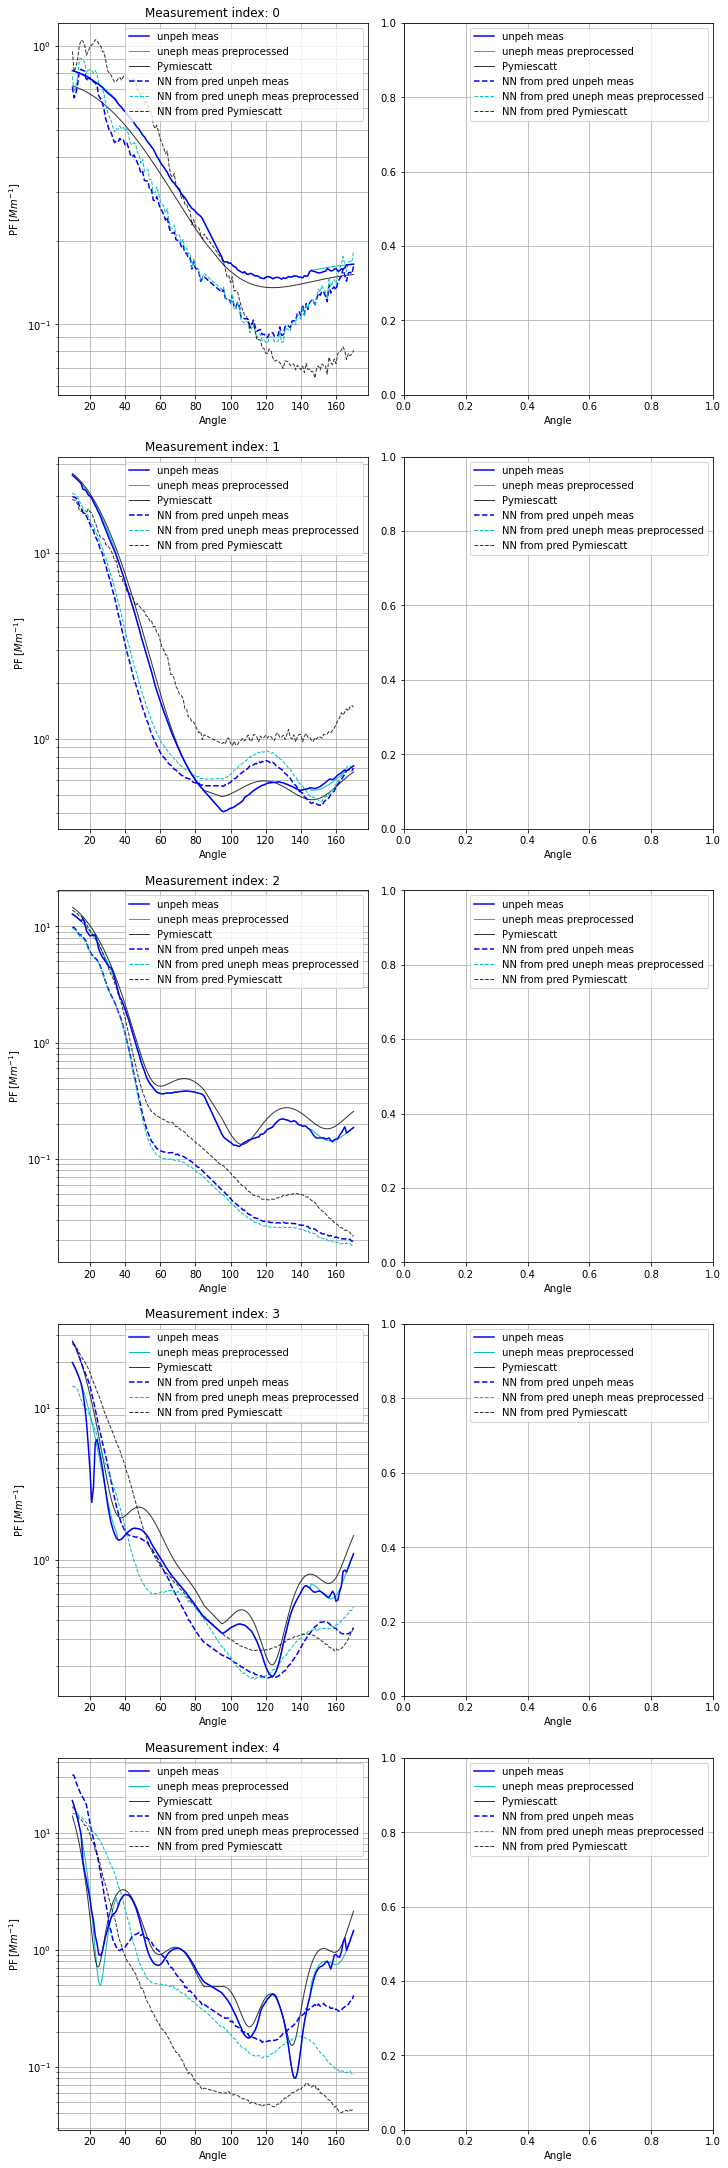

In [30]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 30), constrained_layout=True)
for index in range(5):
    axs[index,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')

    meas_prepro_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')

        
    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')

        
        

        
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred0_4.jpg')


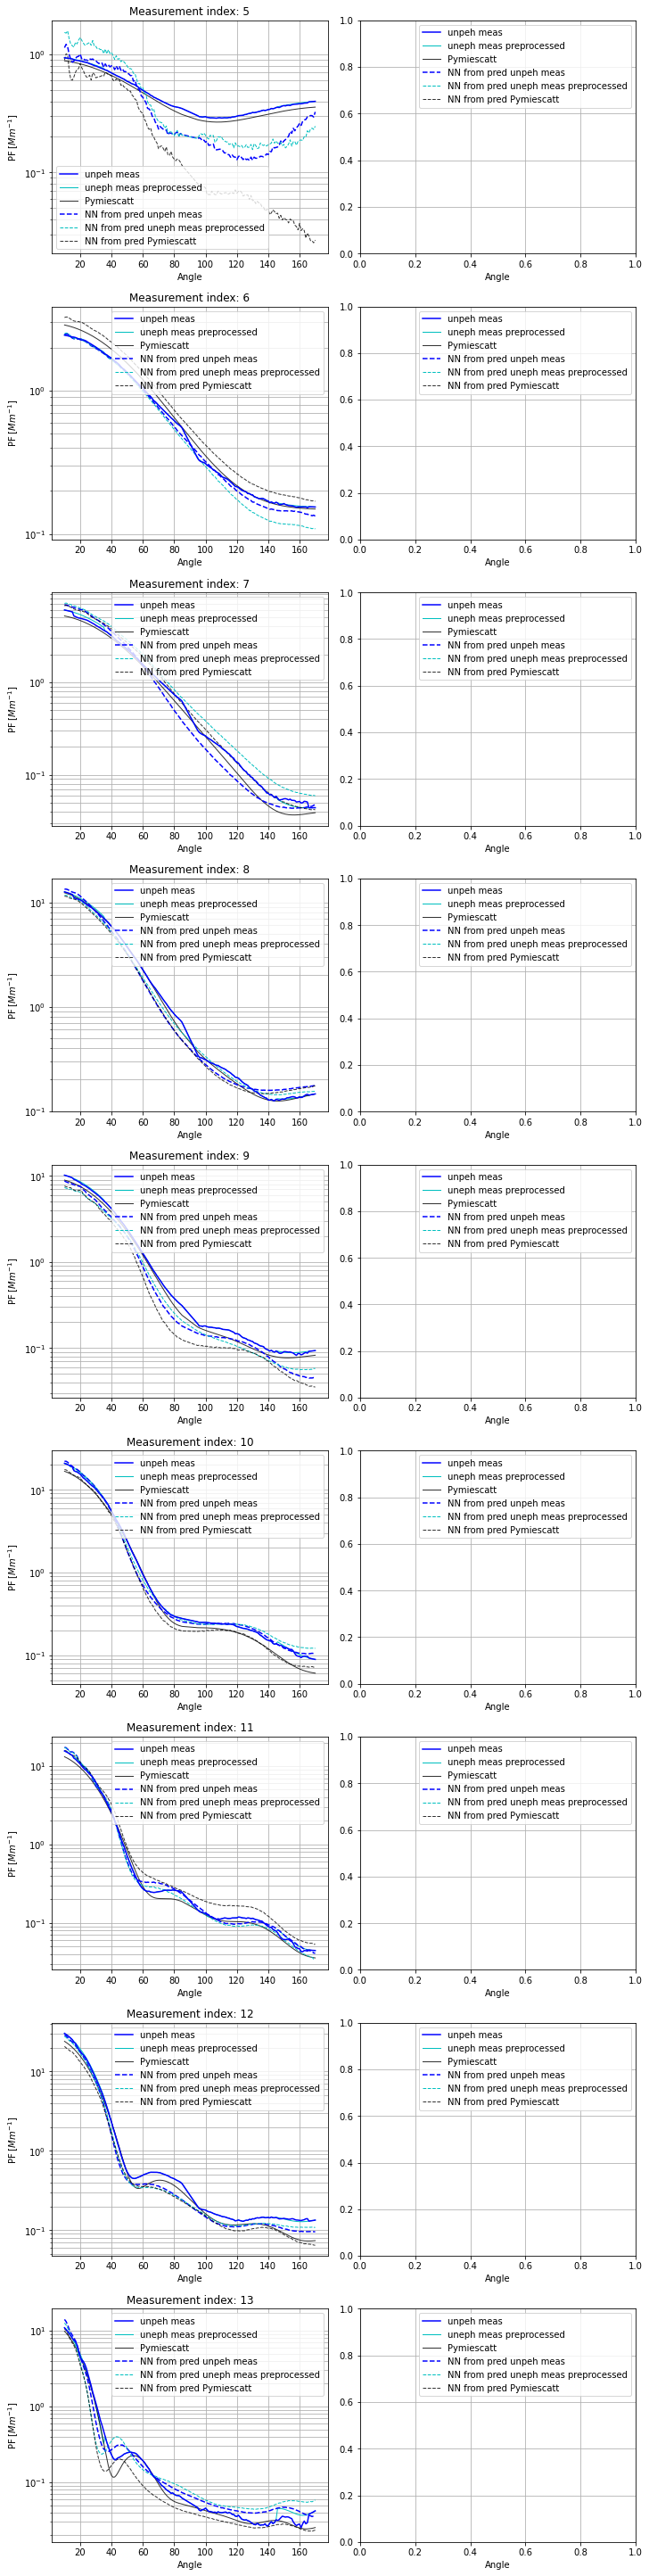

In [31]:

fig, axs = plt.subplots(ncols=2, nrows=9, figsize=(10, 40), constrained_layout=True)
for index in range(5,14):
    axs[index-5,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')

    meas_prepro_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')

        
    meas_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')

        
        

        
    axs[index-5,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index-5,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred5_13.jpg')


# Make predictions with Pymiescatt

In [34]:
D_array = np.logspace(0.1, 5, 300)

In [35]:
angles_new = np.arange(10,171)
len(angles_new)

161

In [36]:
qoi_list_pms_F11 = []
qoi_list_pms_PPF = []
qoi_list_pms = []
for i in range(10,171):
    qoi_list_pms.append('F11_'+str(i))
    qoi_list_pms_F11.append('F11_'+str(i))
for i in range(10,171):
    qoi_list_pms.append('PPF_'+str(i))
    qoi_list_pms_PPF.append('PPF_'+str(i))


In [37]:
# qoi with Pymiescatt: prediction of measurement data
pms_qoi_meas_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
#pms_qoi_meas_pred.loc[index]=np.concatenate([pms_hdf['F11'].T.values,pms_hdf['PPF'].T.values])
pms_qoi_meas_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pred.csv') 

205.00561750974396
152.1937322544798
484.7290617415954
116.7665655272214
609.4076370624567
19.930610084830164
773.2770816627396
10.61957410692383
859.7012184032345
10.796644233323278
269.79805247479186
24.138666111229146
235.3136272407171
275.6302205401706
322.3040684631791
276.7559361473839
350.7831471527283
238.78264114770556
408.4592995254493
57.57632534289628
480.0610079772452
90.58934713980457
580.8935153497815
29.438010650527904
646.0408865549764
46.30461145098345
877.8589982184458
7.307213265735842


In [38]:

# qoi with Pymiescatt: prediction of processed measurement data
pms_qoi_meas_preprocessed_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_preprocessed_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/pms_qoi_meas_preprocessed_pred.csv') 

206.19550561168006
141.12684862679703
478.2486063887138
123.58429040680876
614.1012302968105
20.21968223610786
644.5245294778223
12.050620949305772
598.4102684909018
19.092379894711154
258.1130387250631
26.962791646822254
241.05438337846633
272.3768633274697
297.9712448341953
188.37535918229094
324.17543626142395
268.7862925557009
384.31790255032905
67.97158023103083
464.5070151673614
96.5725760394796
578.6789631092446
31.2343316883345
635.9225998320314
49.68309452263829
945.0761479531493
6.008229159283327


In [39]:
# qoi with Pymiescatt: prediction of with pymiescatt predicted measurement data
pms_qoi_meas_pymiescatt_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pymiescatt_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pymiescatt_pred.csv') 

226.86653121180396
96.13793021284928
445.3431525630895
93.56094841371738
619.4366123950016
20.90868392219064
587.4894032488033
23.059688940351613
882.1587119180318
3.9597173062464095
289.9680502619162
19.305440859148714
230.63900505799282
290.8206629277251
300.9939582619397
216.45451930775337
347.0059140042467
215.09666425930615
418.27299447151756
46.65112404976984
471.79182311028
75.62918928006776
526.1679395710709
38.34318904538522
602.1044080639697
37.04985635030233
928.2842230837874
5.660183604719293


In [32]:
# Calculate relative error for aerosol retrieval

def rel_error(true, pred):
    relative_error = np.abs(true-pred)/np.abs(true)*100
    return relative_error
relerr1 = rel_error(dvar_meas, dvar_meas_pred)
print(relerr1.mean())
relerr2 = rel_error(dvar_meas, dvar_meas_preprocessed_pred)
print(relerr2.mean())
relerr3 = rel_error(dvar_meas, dvar_meas_pymiescatt_pred)
print(relerr3.mean())

qoi_meas.columns = qoi_meas.columns.str.replace('_0.532_','_')
qoi_meas[F11_list] = np.exp(qoi_meas[F11_list])
qoi_pred[F11_list] = np.exp(qoi_pred[F11_list])
qoi_meas_pred[F11_list] = np.exp(qoi_meas_pred[F11_list])
qoi_meas_preprocessed_pred[F11_list] = np.exp(qoi_meas_preprocessed_pred[F11_list])
qoi_meas_pymiescatt_pred[F11_list] = np.exp(qoi_meas_pymiescatt_pred[F11_list])
relerr4 = rel_error(qoi_meas, qoi_pred)
relerr5 = rel_error(qoi_meas, qoi_meas_pred)
relerr6 = rel_error(qoi_meas, qoi_meas_preprocessed_pred)
relerr7 = rel_error(qoi_meas, qoi_meas_pymiescatt_pred)
rel_error_df_iv0_4 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv0_4.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[0:4].mean(), relerr1['RmedianV'].loc[0:4].mean(), relerr1['GSD'].loc[0:4].mean(), relerr1['n'].loc[0:4].mean(), relerr1['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[0:4].mean(), relerr2['RmedianV'].loc[0:4].mean(), relerr2['GSD'].loc[0:4].mean(), relerr2['n'].loc[0:4].mean(), relerr2['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_pymiescatt_pred'] = [relerr3['Vtot'].loc[0:4].mean(), relerr3['RmedianV'].loc[0:4].mean(), relerr3['GSD'].loc[0:4].mean(), relerr3['n'].loc[0:4].mean(), relerr3['k'].loc[0:4].mean()]
rel_error_df_iv0_4 = np.round(rel_error_df_iv0_4, decimals = 2)
rel_error_df_iv0_4
rel_error_df_iv5_13 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv5_13.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[5:13].mean(), relerr1['RmedianV'].loc[5:13].mean(), relerr1['GSD'].loc[5:13].mean(), relerr1['n'].loc[5:13].mean(), relerr1['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[5:13].mean(), relerr2['RmedianV'].loc[5:13].mean(), relerr2['GSD'].loc[5:13].mean(), relerr2['n'].loc[5:13].loc[5:13].mean(), relerr2['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_pymiescatt_pred'] = [relerr3['Vtot'].loc[5:13].mean(), relerr3['RmedianV'].loc[5:13].mean(), relerr3['GSD'].loc[5:13].mean(), relerr3['n'].loc[5:13].mean(), relerr3['k'].loc[5:13].mean()]
rel_error_df_iv5_13 = np.round(rel_error_df_iv5_13, decimals = 2)
rel_error_df_iv5_13

rel_error_df_fw0_4 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw0_4.loc['meas_vs_pred'] = [relerr4[F11_list].loc[0:4].mean().mean(),relerr4[PPF_list].loc[0:4].mean().mean()]
rel_error_df_fw0_4.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[0:4].mean().mean(),relerr5[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[0:4].mean().mean(),relerr6[PPF_list].loc[0:4].mean().mean()]
rel_error_df_fw0_4.loc['meas_vs_meas_pymiescatt_pred'] = [relerr7[F11_list].loc[0:4].mean().mean(),relerr7[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4 = np.round(rel_error_df_fw0_4, decimals = 2)
rel_error_df_fw0_4

rel_error_df_fw5_13 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw5_13.loc['meas_vs_pred'] = [relerr4[F11_list].loc[5:13].mean().mean(),relerr4[PPF_list].loc[5:13].mean().mean()]
rel_error_df_fw5_13.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[5:13].mean().mean(),relerr5[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[5:13].mean().mean(),relerr6[PPF_list].loc[5:13].mean().mean()]
rel_error_df_fw5_13.loc['meas_vs_meas_pymiescatt_pred'] = [relerr7[F11_list].loc[5:13].mean().mean(),relerr7[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13 = np.round(rel_error_df_fw5_13, decimals = 2)
rel_error_df_fw5_13
rel_error_df_iv0_4.to_csv(f'{plot_dir}/rel_error_df_iv0_4.csv')
rel_error_df_iv5_13.to_csv(f'{plot_dir}/rel_error_df_iv5_13.csv')
rel_error_df_fw0_4.to_csv(f'{plot_dir}/rel_error_df_fw0_4.csv')
rel_error_df_fw5_13.to_csv(f'{plot_dir}/rel_error_df_fw5_13.csv')

Vtot           50.448264
RmedianV       11.773371
GSD             2.816966
n              13.302771
k           33816.699543
dtype: float64
Vtot           47.197220
RmedianV       13.374294
GSD             2.530684
n              11.249166
k           36207.095886
dtype: float64
Vtot           36.245654
RmedianV       13.474202
GSD             2.276486
n              18.172775
k           14370.334147
dtype: float64


<ipython-input-32-b77a23c2356d>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  qoi_meas.columns = qoi_meas.columns.str.replace('_0.532_','_')


F11  PPF
meas_vs_pred                    17.43  NaN
meas_vs_meas_pred               18.43  NaN
meas_vs_meas_preprocessed_pred  22.33  NaN
meas_vs_meas_pymiescatt_pred    28.58  NaN